# Examples

In [2]:
import pandas as pd
import numpy as np
from degiro_analytics import DeGiroWrapper
from degiro_analytics.utils import irr, analytics
DGW = DeGiroWrapper(True, True, base_curr='EUR') # you will have to provide your credentials (and possibly multi-factor auth code)

Your session has expired. Logging in again...
Please type in your credentials.
Your credentials are invalid
Please type in your credentials.


## Insights into your portfolio

In [3]:
pf = DGW.get_current_portfolio() # retrieves your current portfolio

Get price history of your portfolio constituents

<AxesSubplot:title={'center':'Portfolio constituents perfomance'}, xlabel='date'>

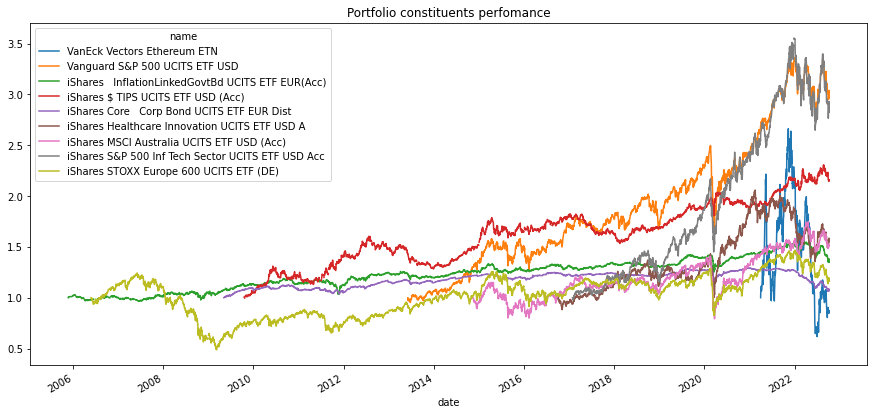

In [4]:
P = DGW.get_prices(pf.index)
P = P.pivot(index='date', columns='name', values='price')
P = P.apply(lambda x: x/x.dropna().iloc[0]) # normalize by starting price
P.plot(title='Portfolio constituents perfomance', figsize=(15, 7))

## Perfomance of your account

In [5]:
start_date = '01/01/2020' # use any date
T = DGW.get_transactions(start_date) # trasactions history
P = DGW.get_prices(T.productId.unique()) # get price history of all products from T
P = P[P.date>=T.date.min()]
P = pd.pivot_table(P, index='date', columns='productId', values='price', aggfunc='mean') # product per columns
P.fillna(method='ffill', inplace=True)

In [6]:
Q = pd.pivot_table(T, index='date', columns='productId', values='quantity', aggfunc='sum') # number of shares purchased, product per column
Q = Q.reindex(P.index.append(Q.index)).sort_index().replace(np.nan, 0).cumsum() # portfolio quantities per day

In [7]:
idx = P.index.get_indexer(Q.index, method='nearest')
matched_P = P.iloc[idx].values

The following cell computes portfolio returns as $R_t = \frac{Q_{t-1}'P_t}{Q_{t-1}'P_{t-1}}$.

In [8]:
numerator = Q.shift().multiply(matched_P).sum(axis=1)
denominator = Q.multiply(matched_P).sum(axis=1).shift()
R = numerator/denominator

<AxesSubplot:title={'center':'Account Portfolio Perfomance'}, xlabel='date'>

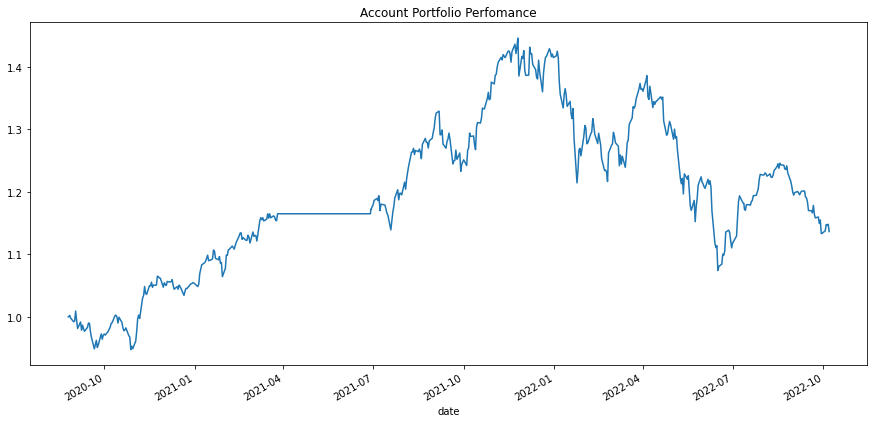

In [9]:
IDX = R.replace(np.nan, 1).cumprod() # index (or normalized price) of the portfolio
IDX.plot(title='Account Portfolio Perfomance', figsize=(15, 7))

Some analytics

In [10]:
analytics(IDX) 

{'Mean return': 0.0002810498733216424,
 'Std': 0.010501160745463613,
 'Risk Adjusted Return': 0.02676369595075981,
 'Number of drawdowns': 28,
 'Maximum Drawdown': 0.25730401117784857,
 'Max drawdown duration (days)': 316,
 'Mean drawdown duration (days)': 25.892857142857142,
 'T': 568}

Cash Flows analysis and money weighted return (IRR)

In [11]:
cf_df = DGW.get_account_cash_flows('01/01/2000', fees=True, dividends=True)
cf = cf_df.set_index('date').CF
cf.loc[pd.to_datetime(DGW.today, dayfirst=True, utc=True)] = pf.Q.multiply(pf.price_base_curr).sum() # current portfolio value

In [12]:
mwr = irr(cf)
print('Money weighted return is', mwr)

Money weighted return is 0.008500000000000004


## Search products

The current price of Microsoft Corp is 234.24 USD


<AxesSubplot:title={'center':'Microsoft Corp'}, xlabel='date'>

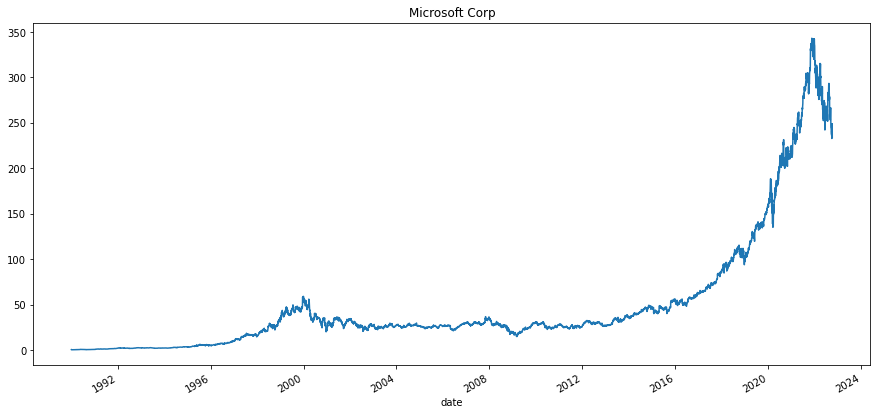

In [13]:
search_text = 'Microsoft'
product = DGW.lookup(search_text, limit=1)[0]
print('The current price of', product.name, 'is', product.closePrice, product.currency)
p = product.get_price_hist(convert=False).set_index('date').price
p.plot(title=product.name, figsize=(15,7))

The current price of Apple Inc is 140.09 USD


<AxesSubplot:title={'center':'Apple Inc (intraday pricing)'}, xlabel='date'>

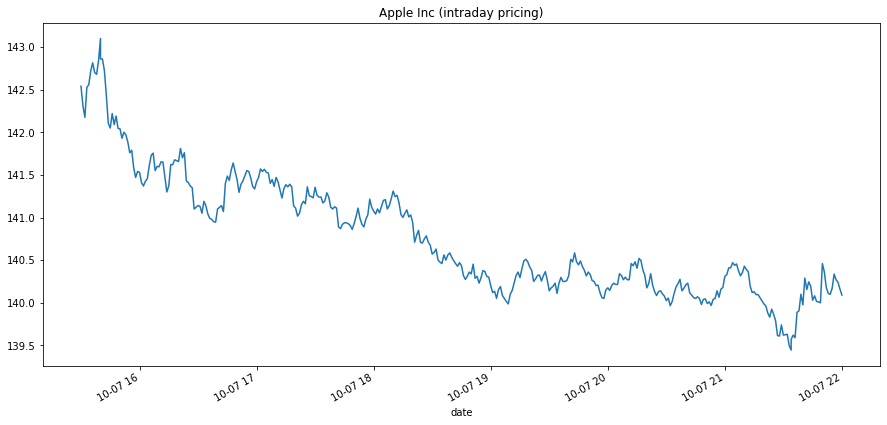

In [13]:
search_text = 'Apple'
product = DGW.lookup(search_text, limit=1)[0]
print('The current price of', product.name, 'is', product.closePrice, product.currency)
p = product.get_price_hist(history='1D', resolution='T1M', convert=False).set_index('date').price
p.plot(title=product.name + ' (intraday pricing)', figsize=(15,7))

## Search and analyze ETFs from core selection

In [14]:
etfs = DGW.search_etfs(only_free=True, limit=200) # returns all ETFs from DeGiro core selection

Loop through the ETFs and analyze the prices

In [15]:
out = []
for etf in etfs:
    p = etf.get_price_hist(resolution='1M')
    a = analytics(p.set_index('date').price)
    a['name'] = etf.name
    out.append(a)

In [16]:
pd.DataFrame(out).sort_values('Risk Adjusted Return')

,Mean return,Std,Risk Adjusted Return,Number of drawdowns,Maximum Drawdown,Max drawdown duration (days),Mean drawdown duration (days),T,name
187,-0.003472,0.024404,-0.142273,6,0.308097,1278,375.333333,80,Xtrackers USD Corporate Bond UCITS ETF 2D HEUR
72,-0.001671,0.012102,-0.138065,5,0.160952,852,329.000000,59,iShares Core Gl Aggregate Bd UCITS ETF EUR Hgd...
185,-0.010793,0.095586,-0.112917,2,0.611792,699,380.000000,27,The Medical Cannabis and Wellness UCITS ETF Acc
130,-0.001517,0.015081,-0.100610,4,0.204085,1064,578.250000,80,Vanguard EUR Eurozone Government Bd UCITS ETF EUR
177,-0.010660,0.106982,-0.099645,2,0.639566,699,380.000000,27,Rize Medical Cannabis and Life Sciences UCITS ETF
...,...,...,...,...,...,...,...,...,...
85,0.016202,0.052215,0.310290,14,0.240527,396,139.357143,78,SPDR MSCI World Technology UCITS ETF
90,0.012146,0.038251,0.317544,23,0.176644,518,166.782609,149,Amundi S&P 500 UCITS ETF- EUR (C)
15,0.015303,0.046139,0.331675,21,0.239507,365,175.523810,142,iShares NASDAQ 100 UCITS ETF USD (Acc)
174,0.023928,0.069757,0.343022,3,0.271599,365,284.333333,31,Lyx Msci Future Etf
